# CONTROLLABILITY


In [1]:
!pip install -q tellurium
!pip install -q controlSBML


[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import tellurium as te
import controlSBML as ctl
import numpy as np

# Helpers

In [3]:
TEST_MODEL = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 3
k1 = 1
k2 = 1
S2 = 0
"""

In [4]:
# Function that adjust model parameters
def plotModel(model, title="", is_plot=True, input_species=None, times=np.linspace(0, 5, 50), selections=None, **kwargs):
    """
    Plots the simulation with the specified parameter values.
    
    Parameters
    ----------
    model: str either antimony or URL
    title: str (plot title)
    is_plot: bool
    input_species: str (species used as input if it is not a boundary/fixed species in the model)
    times: array-float (times for simulations)
    selections: list-str (species to plot)
    kwargs: dict
        key: parameter name
        value: parameter value
    
    Returns
    -------
    NamedArray
    """
    if "http" in model:
        rr = te.loadSBMLModel(model)
    else:
        rr = te.loada(model)
    if input_species is not None:
        rr.setBoundary(input_species, True)
    if selections is not None:
        new_selections = list(selections)
        if not "time" in selections:
            new_selections.insert(0, "time")
    else:
        new_selections = selections
    for name, value in kwargs.items():
        rr[name] = value
    simulation_results = rr.simulate(times[0], times[-1], len(times), selections=new_selections)
    if is_plot:
        rr.plot(simulation_results, title=title)
    return simulation_results
    
# TESTS
results = plotModel(TEST_MODEL, input_species="S1", is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


# Controllability

Consider a system with input $u(t)$ and output $y(t)$ that we want to regulate over the region $y_L \leq y(t) \leq y_H$. The system is controllable if there are values of $u(t)$ such that $y(t)$ can achieve the desired values.

In [5]:
MODEL1 = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

$S1 = 2
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find $S_1$ that produces $S_2 = 3$

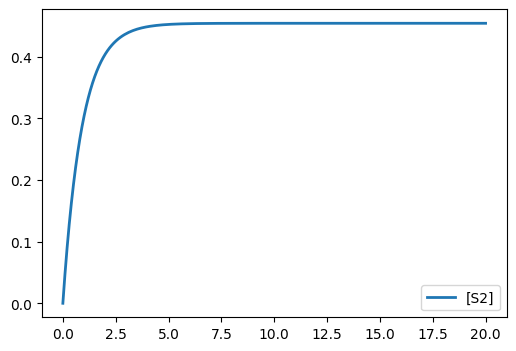

In [6]:
_ = plotModel(MODEL1, times=np.linspace(0, 20, 200), S1=1)

Not all systems are controllable.

In [7]:
MODEL2 = """
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find a value of S1 that results in S2 = 2.

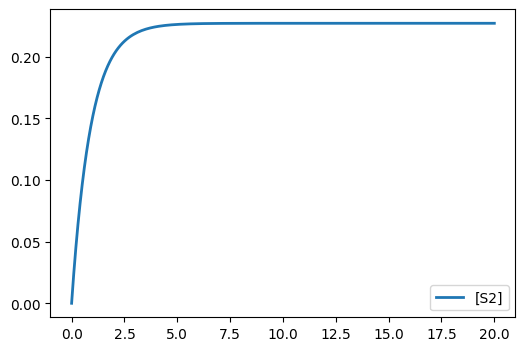

In [8]:
_ = plotModel(MODEL2, times=np.linspace(0, 20, 200), S1=1)

## mTOR system



<img src="mtor.png"
     alt="Markdown Monster icon" 
     width="1000" height="1200"
     style="float: left; margin-right: 10px;" />

In [9]:
# mTOR model
MTOR_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"

Problem: What are the names of the species?

In [10]:
rr = te.loadSBMLModel(MTOR_URL)
rr.getFloatingSpeciesIds()

['IR',
 'pIR',
 'IRS',
 'pIRS',
 'iIRS',
 'Akt',
 'pAkt',
 'mTORC1',
 'pmTORC1',
 'mTORC2',
 'pmTORC2',
 'imTORC2',
 'mTORC1_DEPTOR',
 'mTORC2_DEPTOR',
 'DEPTOR',
 'pDEPTOR']

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/lectures/lecture_05-controllability/mtor.png" width="300" height="225" /></a>


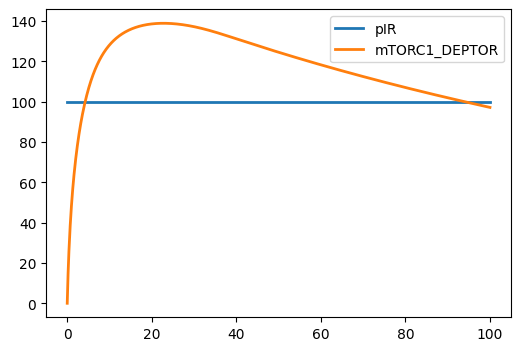

In [11]:
_ = plotModel(MTOR_URL,  input_species="pIR", selections=["pIR", "mTORC1_DEPTOR"], pIR=100, times=np.linspace(0, 100, 1000))

# Evaluating Controllability

Look at the response to the input over a series of steps. The series of steps is called a **staircase**. A staircase has an initial value, a final value, and a number of steps. This is implemented by using Antimony **events**. An event is a statement executed once when a condition is true. We condition on the variable **time**.

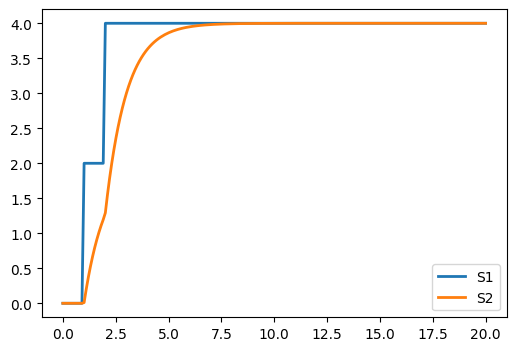

In [14]:
MODEL3 = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 0
k1 = 1
k2 = 1
S2 = 0

at time > 0: S1 = 0
at time > 5: S1 = 2
at time > 10: S1 = 4
at time > 15: S1 = 8
"""
_ = plotModel(MODEL3, times=np.linspace(0, 20, 200), input_species="S1", selections=["S1", "S2"])

# ControlSBML